###### Importing Libraries

In [2]:
from numpy import *
from matplotlib.pyplot import *
from matplotlib import cm, colors
from time import time
import pandas as pd

# Localy Sensitive Hashing Timing Analysis

The training time for LSH is given by $ O(NDL) $ while test time is given by $ O(DL+DT) $ where T is the average number of training samples with the same hash, $ N $ is the number of samples, $ D $ is the number of features and $ L $ is the number of hash-tables. Now, first, I'll show that $ T $ is $ O(N \times 2^{-L}) $ , giving us the estimate of testing time as  $ O(DL+\dfrac{ND}{2^L}) $



### Number of regions

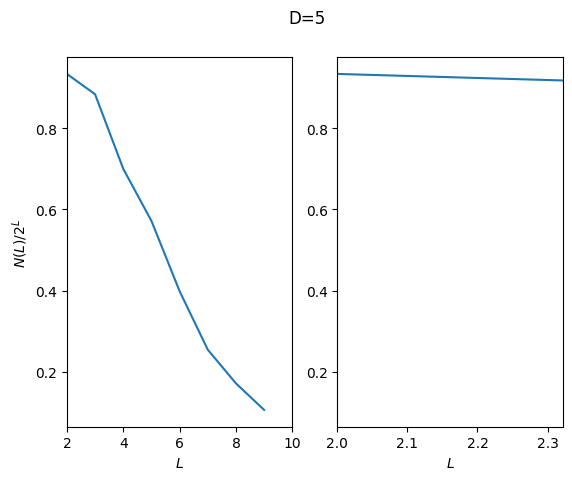

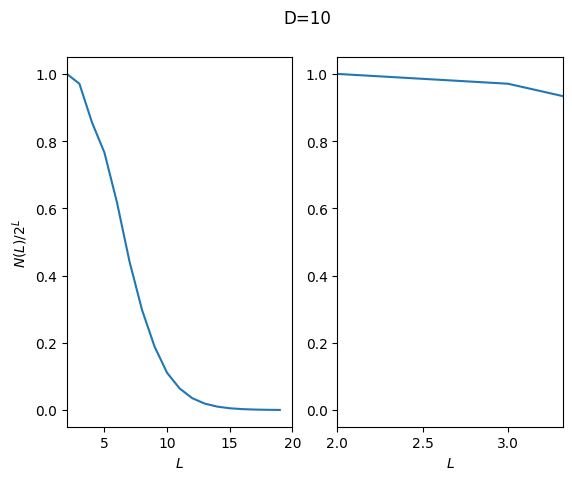

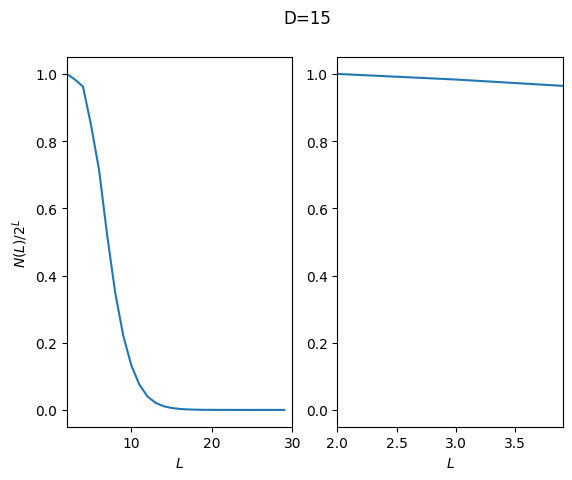

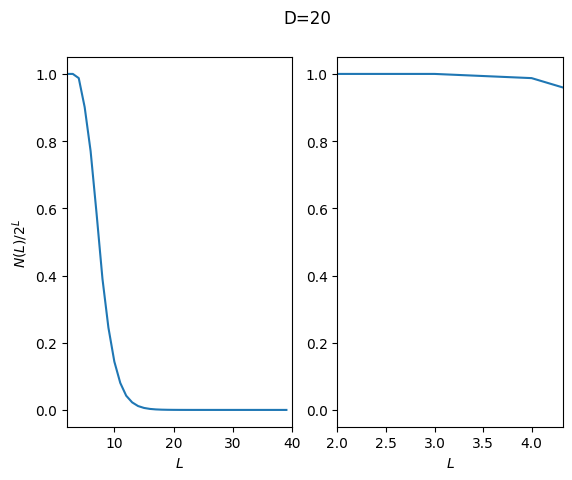

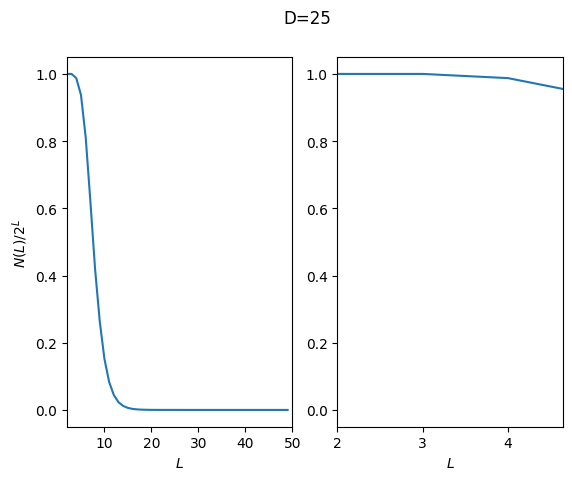

In [76]:
for d in range(5,30,5):
    l = []
    iterat = 30
    for L in range(2,2*d):
        S = 0
        for it in range(iterat):
            X = 2*random.random((200,d))-1
            X = array([list(x)+[1] for x in X])
            W = 2*random.random((L,d+1))-1
            Y = X @ W.T
            Y = around((sign(Y)+1)/2)
            Y = array(Y,dtype=int64)
            S += len(unique(Y,axis=0))
        S = S/iterat
        l.append(S/(2**L))
    f = figure()
    s1 = f.add_subplot(121)
    s2 = f.add_subplot(122)
    s1.plot(range(2,2*d),l)
    s1.set_xlim(2,2*d)
    s1.set_xlabel('$ L $')
    s1.set_ylabel('$ N(L)/2^L $')
    s2.plot(range(2,2*d),l)
    s2.set_xlim(2,(log2(d)))
    s2.set_xlabel('$ L $')
    f.suptitle(f"D={d}")

### Expected number of computations for each example during testing phase of model

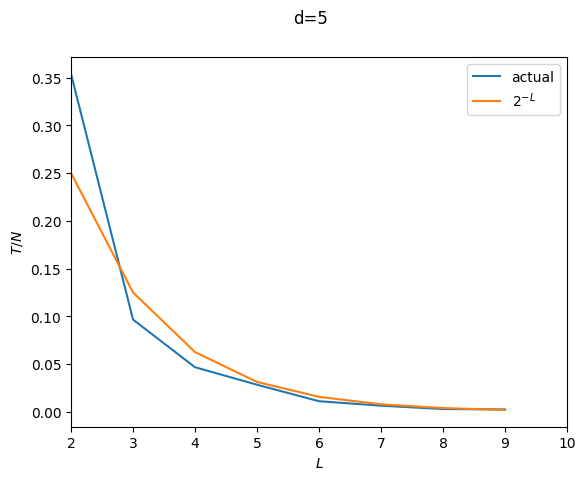

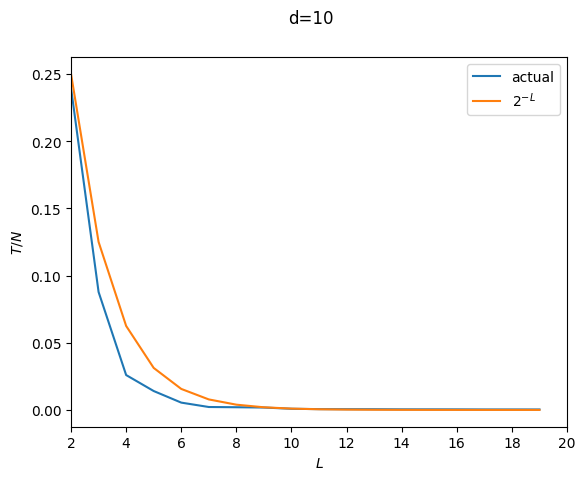

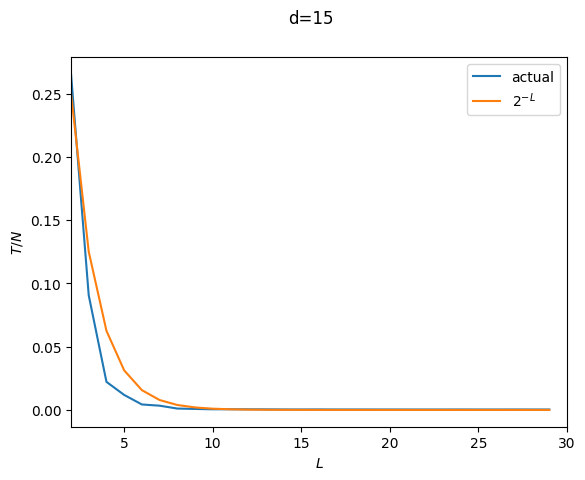

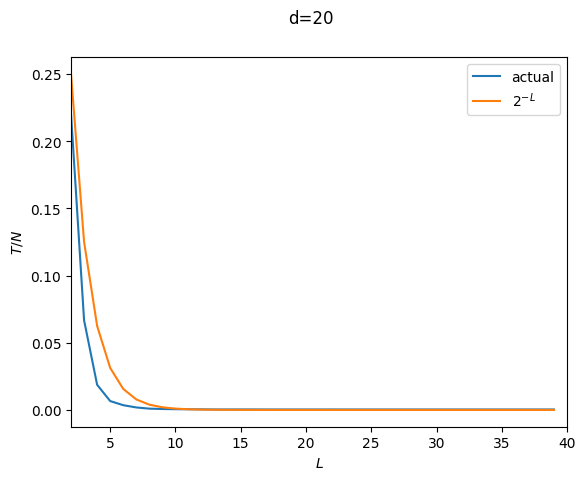

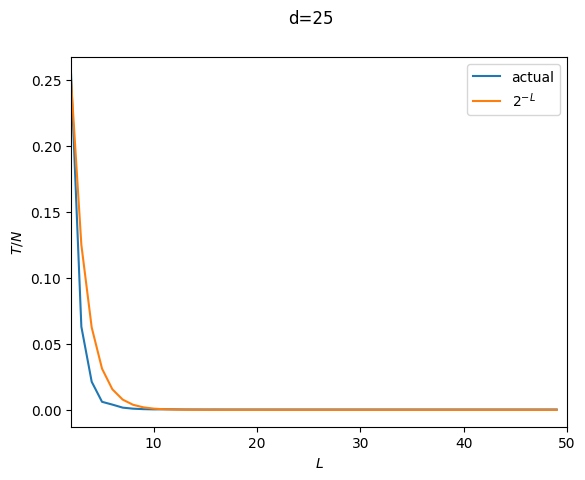

In [75]:
N = 100
for d in range(5,30,5):
    l = []
    iterat = 30
    for L in range(2,2*d):
        S = 0
        for it in range(iterat):
            X = 2*random.random((N,d))-1
            X = array([list(x)+[1] for x in X])
            W = 2*random.random((L,d+1))-1
            Y = X @ W.T
            Y = (Y>=0)
            Y = array(Y,dtype=int64)
            assert Y.shape[0] == N
            values,counts = unique(Y,axis=0,return_counts=True)
            K = len(counts)
            counts = array(counts)
            counts = counts * counts / K
            S = sum(counts)
        S = S/iterat
        l.append(S/N)
    f = figure()
    s1 = f.add_subplot()#(121)
    #s2 = f.add_subplot(122)
    s1.plot(range(2,2*d),l)
    s1.plot(range(2,2*d),[2**-x for x in range(2,2*d)])
    s1.set_xlim(2,2*d)
    s1.set_xlabel('$ L $')
    s1.set_ylabel(r"$ T/N $")
    #s2.plot(range(2,2*d),l)
    #s2.plot(range(2,2*d),[2**-x for x in range(2,2*d)])
    #s2.set_xlim(2,(log2(d)))
    #s2.set_xlabel('$ L $')
    f.suptitle(f"d={d}")
    legend(["actual",'$ 2^{-L} $ '])

# Question

In this question you will implement and compare the following different KNN variants (we will
discuss the a) and b) part of this in the upcoming tutorial)
a. LSH (1.5 marks)
b. KD-tree (1.5 marks)
c. Naive version of KNN (0.5 marks)Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory
comparison for finding $K$ nearest neighbours. (1 mark)
Now, in a 2d randomly generated dataset visually show how many of the $K$ closest
neighbours appx. $K$ NN methods miss out due to their approximate nature.
Also show the partitions in the 2d space. (0.5 marks)

# Answer

### LSH

##### Class for LSH

In [96]:
class LSH:
    def initialise_weights(self,D,L):
        self.W = 2*random.random((L,D+1))-1
    def train(self,X,y,L):
        self.y = y
        self.X = X
        N,D = X.shape
        X = array([list(x)+[1] for x in X])
        t0 = time()
        self.initialise_weights(D,L)
        W = self.W
        Y = X @ W.T
        Y = (Y>=0).astype(int64)
        self.y = y
        binc = array([2**i for i in range(L)])
        self.binc = binc
        Y = dot(Y,binc)
        hashes = unique(Y,axis=0)
        Dic = {}
        for h in hashes:
            H = int(h)
            sl = (Y==h)
            sl = where(sl)
            Xh = X[sl]
            yh = y[sl]
            Dic[H] = (Xh,yh)
        self.Dic = Dic
        t = time()
        dt = t-t0
        return dt

    def predict(self,x,k,continuous=True,return_time=False):
        x = array(list(x)+[1])
        t0 = time()
        h = dot(self.W,x)
        h = (h>=0).astype(int64)
        h = dot(h,self.binc)
        H = int(h)
        if H not in self.Dic:
            if return_time:
                return random.choice(self.y),None
            return random.choice(self.y)
        Xh,yh = self.Dic[H]
        if len(yh) == 0:
            if return_time:
                return random.choice(self.y),None
            return random.choice(self.y)
        #assert len(yh) > 0, H
        er = Xh-x
        dist2 = sum(er**2,axis=1)
        i = argpartition(dist2,min(k,len(dist2)-1))[:k]
        #assert len(i.shape) == 1 , i
        y = yh[i]
        yp = None
        if continuous:
            yp =  mean(y)
        else:
            values,counts = unique(y,return_counts=True)
            i = argmax(counts)
            i = int(i)
            yp =  values[i]
        t = time()
        dt = t- t0
        if return_time :
            return yp, dt
        return yp


##### function to create Data

In [4]:
def LinearData(N=100,D=2,err=0.05,continuous=True,scale=10):
    X = random.random((N,D))
    W = 2*random.random(D)-1
    y = scale*dot(X,W)
    y = y + err*random.random(N)
    if not continuous:
        y = y.astype(int64)
    return X,y

#### 2 Dimensional Data visualisation

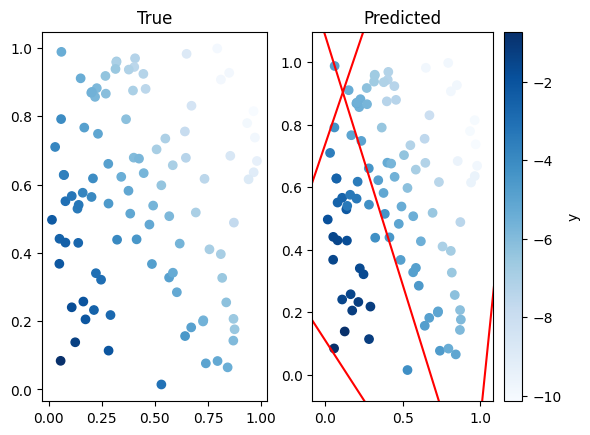

In [5]:
N,D,L,err,scale = 100,2,10,0.5,5
X,y = LinearData(N,D,err,scale)
Clf = LSH()
Clf.train(X,y,L)
Dic = Clf.Dic
yp = []
for i in range(N):
    yp.append(Clf.predict(X[i],5,True))
yp = array(yp)
f = figure()
s1 = f.add_subplot(121)
s2 = f.add_subplot(122)
s1.scatter(X[:,0],X[:,1],c=y,cmap='Blues')
s2.scatter(X[:,0],X[:,1],c=yp,cmap='Blues')
s1.set_title('True')
s2.set_title('Predicted')
cmap = cm.get_cmap("Blues")
norm = colors.Normalize(min(y),max(y))
c = f.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=s2)
c.set_label('y')
x = linspace(min(X[:,0])-1,max(X[:,0])+1,100)
for w in Clf.W:
    if(w[1]!=0):
        y = (w[0]*x - w[2])/w[1]
    s2.plot(x,y,'r')
s2.set_ylim(min(X[:,1])-0.1,max(X[:,1])+0.1)
s2.set_xlim(min(X[:,0])-0.1,max(X[:,0])+0.1)
show()

#### Time

#### creating analysis data

In [38]:
def Time(Nrange = [10,20,2],Drange = [1,3,1],Lrange=[1,5,1],Krange=[1,5,1],iterations=5):
    Nmin,Nmax,Nstep = Nrange
    Dmin,Dmax,Dstep = Drange
    Lmin,Lmax,Lstep = Lrange
    Kmin,Kmax,Kstep = Krange
    Nsample = (Nmax-Nmin)//Nstep + 1
    Dsample = (Dmax-Dmin)//Dstep + 1
    Lsample = (Lmax-Lmin)//Lstep + 1
    Ksample = (Kmax-Kmin)//Kstep + 1
    Train_time = zeros((Nsample,Dsample,Lsample,Ksample))
    Test_time = zeros((Nsample,Dsample,Lsample,Ksample))
    Accuracy = zeros((Nsample,Dsample,Lsample,Ksample))
    Data = []
    Clf = LSH()

    for n in range(Nsample):
        N = n*Nstep + Nmin
        for d in range(Dsample):
            D = d*Dstep + Dmin
            for l in range(Lsample):
                for k in range(Ksample):
                    K = k*Kstep + Kmin
                    L = l*Lstep + Lmin
                    T = 0
                    t = 0
                    accuracy = 0
                    for i in range(iterations):
                        X,y = LinearData(2*N,D,0.01,False,3)
                        X,Xt = X[:N],X[N:]
                        y,yt = y[:N],y[N:]
                        T += Clf.train(X,y,L)
                        Dt = 0
                        Acc = 0
                        for j in range(N):
                            yp,dt = Clf.predict(Xt[j],K,False,True)
                            if dt is None:
                                continue
                            Acc += int(int(yp)==int(yt[j]))
                            Dt += dt
                        t += Dt
                        Acc = Acc/N
                        accuracy += Acc
                    accuracy = accuracy/iterations
                    assert accuracy >= 0
                    T = T/iterations
                    t = t/(iterations*N)
                    assert accuracy <= iterations*N
                    Train_time[n,d,l,k] = T
                    Test_time[n,d,l,k] = t
                    Accuracy[n,d,l,k] = accuracy
                    Data.append([N,D,L,K,T,t,accuracy])
    Data = array(Data)
    Data = pd.DataFrame(Data,columns=['N','D','L','K','train_time','test_time','accuracy'])
    return Data, Train_time, Test_time, Accuracy


In [120]:
Nmin,Nmax,Nstep = 20,100,20
Dmin,Dmax,Dstep = 5,20,5
Lmin,Lmax,Lstep = 0,30,5
Kmin,Kmax,Kstep = 2,8,2
Data, Train_time, Test_time, Accuracy = Time(
    [Nmin,Nmax,Nstep],
    [Dmin,Dmax,Dstep],
    [Lmin,Lmax,Lstep],
    [Kmin,Kmax,Kstep],
    30
)
Data

,N,D,L,K,train_time,test_time,accuracy
0,20.0,5.0,0.0,2.0,0.000357,0.000085,0.485000
1,20.0,5.0,0.0,4.0,0.000211,0.000077,0.441667
2,20.0,5.0,0.0,6.0,0.000294,0.000112,0.445000
3,20.0,5.0,0.0,8.0,0.000238,0.000097,0.420000
4,20.0,5.0,5.0,2.0,0.000219,0.000064,0.448333
...,...,...,...,...,...,...,...
555,100.0,20.0,25.0,8.0,0.000792,0.000012,0.030000
556,100.0,20.0,30.0,2.0,0.000875,0.000007,0.022333
557,100.0,20.0,30.0,4.0,0.000883,0.000006,0.018667
558,100.0,20.0,30.0,6.0,0.000824,0.000006,0.018333


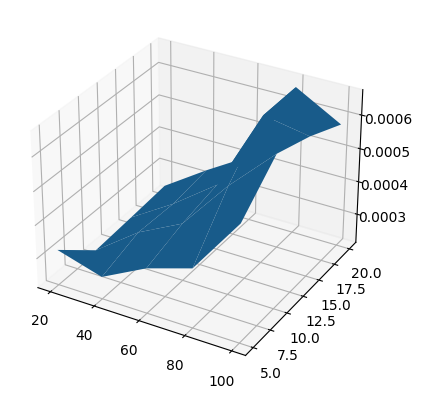

In [121]:
Train_time_ND = mean(Train_time,axis=(2,3))
N = arange(Nmin,Nmax+Nstep/2,Nstep)
D = arange(Dmin,Dmax+Dstep/2,Dstep)
N,D = meshgrid(N,D)
from mpl_toolkits import mplot3d
ax =axes(projection='3d')
ax.plot_surface(N,D,Train_time_ND.T)
show()

#### Functions to visualise

In [122]:
def PixPlot(Tit,MAT,xminL,xmaxL,yminL,ymaxL,xlabL,ylabL,xaxyaxL=None):
    print(amin(MAT))
    print(amax(MAT))
    norm = colors.Normalize(amin(MAT),amax(MAT))
    l = len(xminL)
    f = figure(figsize=(12,3*l//2))
    cmap = cm.get_cmap("viridis")
    CM = cm.ScalarMappable(norm=norm,cmap=cmap)
    axL = []
    for i in range(l):
        xlab = xlabL[i]
        ylab = ylabL[i]
        xmin = xminL[i]
        xmax = xmaxL[i]
        ymin = yminL[i]
        ymax = ymaxL[i]
        if xaxyaxL is not None:
            xaxyax = xaxyaxL[i]
            xax,yax = xaxyax
            tup = tuple(d for d in range(len(MAT.shape)) if d not in xaxyax)
            Mat = mean(MAT,axis=tup)
            if xax < yax :
                Mat = Mat.T
        else : 
            Mat = MAT
        ax = f.add_subplot(int(f"{(l+1)//2}2{i+1}"))
        axL.append(ax)
        im = ax.imshow(Mat,cmap=cmap)
        xticks([0,Mat.shape[1]-1],[xmin,xmax])
        yticks([0,Mat.shape[0]-1],[ymin,ymax])
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
    c = f.colorbar(CM, ax=array(axL))
    c.set_label(Tit)
    f.suptitle(Tit)

def LinePlot(ylab,Mat,xmin,xmax,xlab,dim):
    tup = tuple(d for d in range(len(Mat.shape)) if d != dim)
    Mat = mean(Mat,axis=tup)
    steps, = Mat.shape
    x = linspace(xmin,xmax,steps)
    figure()
    plot(x,Mat)
    xlabel(xlab)
    ylabel(ylab)
    title(ylab + ' vs ' + xlab)

#### Training Time

0.00013309319814046224
0.001400144894917806


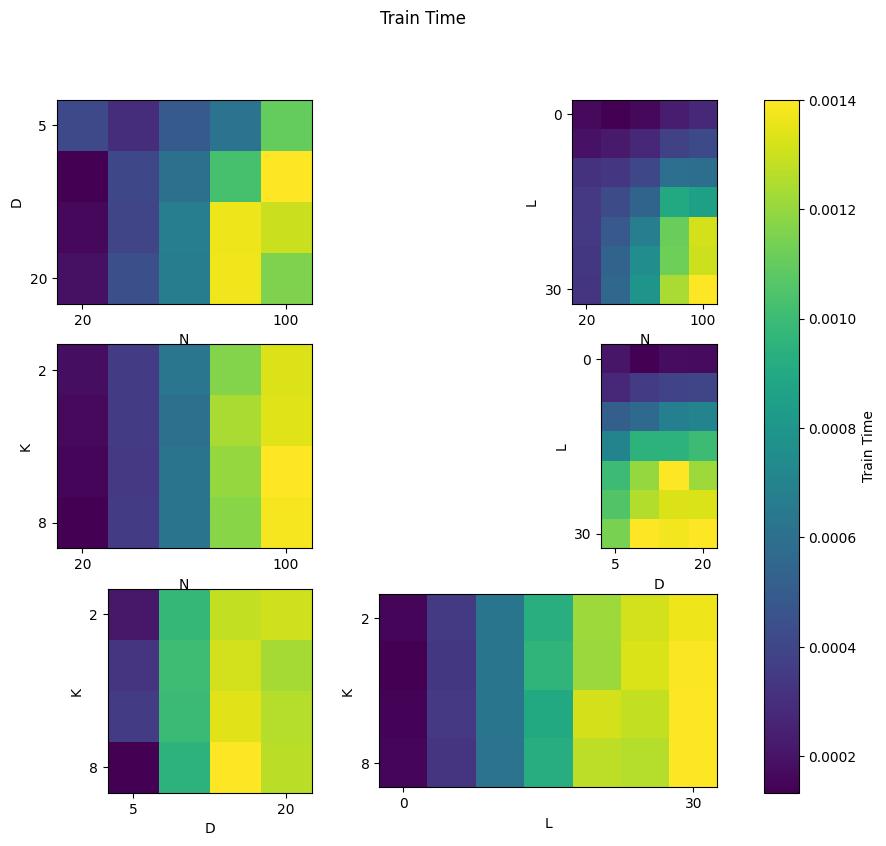

In [123]:
PixPlot("Train Time",Train_time,
        [Nmin]*3+2*[Dmin]+[Lmin],
        [Nmax]*3+2*[Dmax]+[Lmax],
        [Dmin,Lmin,Kmin,Lmin,Kmin,Kmin],
        [Dmax,Lmax,Kmax,Lmax,Kmax,Kmax],
        ['N']*3+['D']*2+['L'],
        ['D','L','K','L','K','K'],
        [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        )

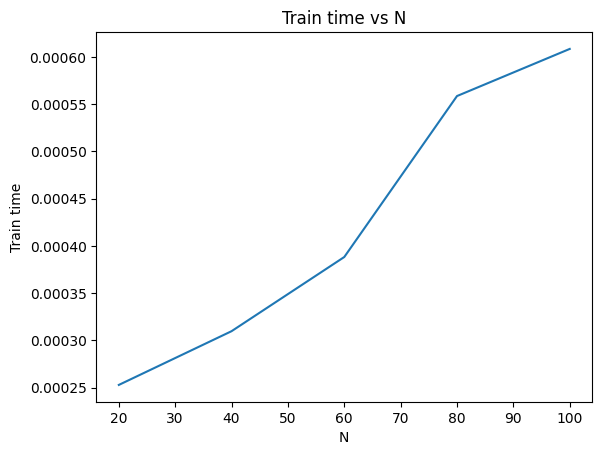

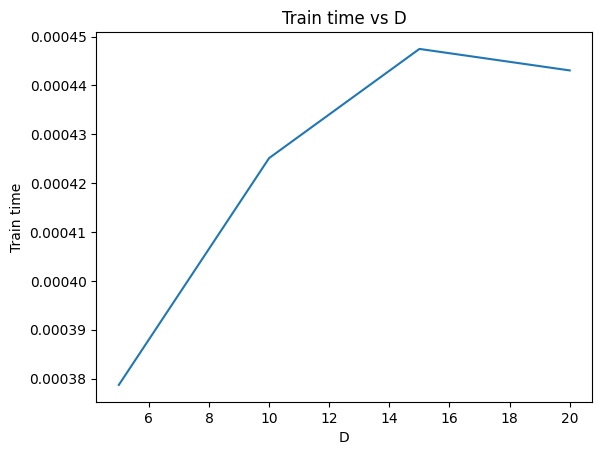

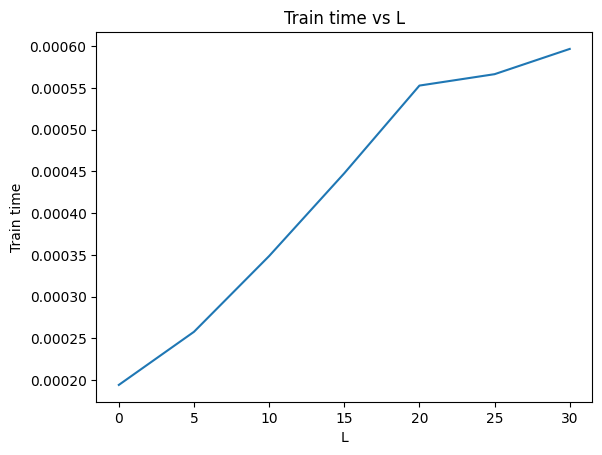

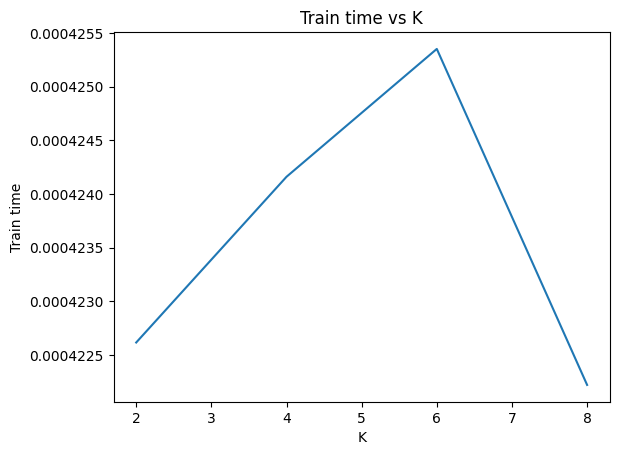

In [124]:
LinePlot('Train time',Train_time,Nmin,Nmax,'N',0)
LinePlot('Train time',Train_time,Dmin,Dmax,'D',1)
LinePlot('Train time',Train_time,Lmin,Lmax,'L',2)
LinePlot('Train time',Train_time,Kmin,Kmax,'K',3)

##### Conclusion : 

Training time doesn't depend on $ K $ . It increases almost linearly with $ N $ , $ L $ and increases with $ D $ . 
This is in agreement with the estimate of $ O(NLD) $


#### Accuracy 

0.0033333333333333335
0.6554166666666664


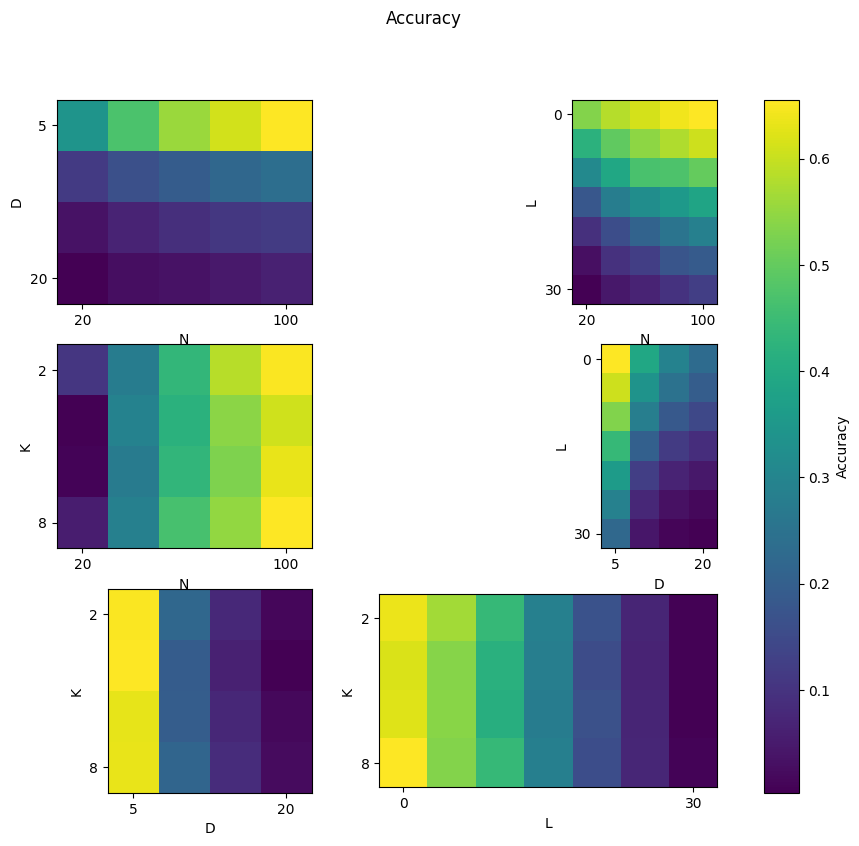

In [125]:
PixPlot("Accuracy",Accuracy,
        [Nmin]*3+2*[Dmin]+[Lmin],
        [Nmax]*3+2*[Dmax]+[Lmax],
        [Dmin,Lmin,Kmin,Lmin,Kmin,Kmin],
        [Dmax,Lmax,Kmax,Lmax,Kmax,Kmax],
        ['N']*3+['D']*2+['L'],
        ['D','L','K','L','K','K'],
        [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        )

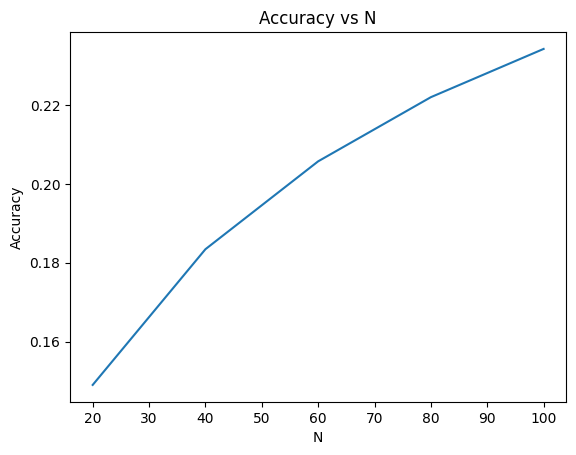

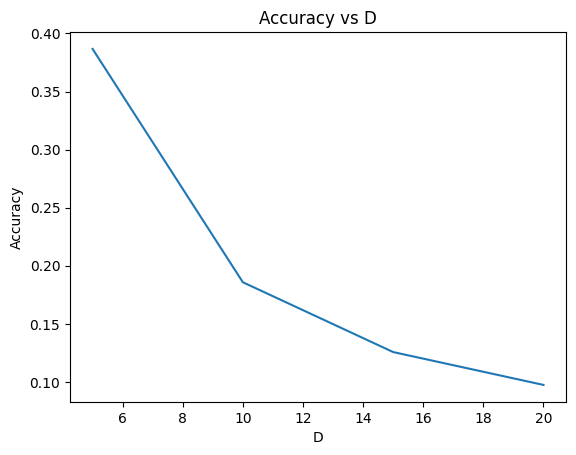

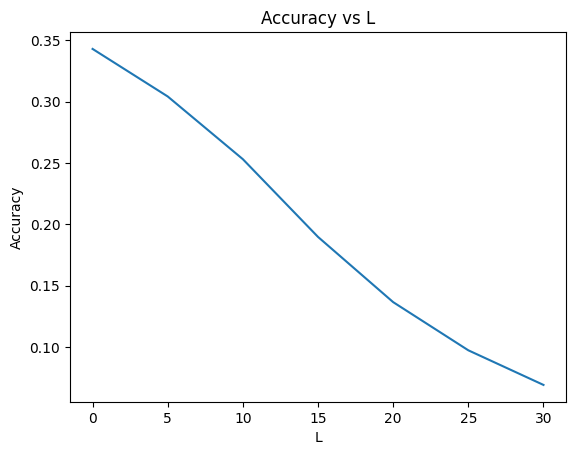

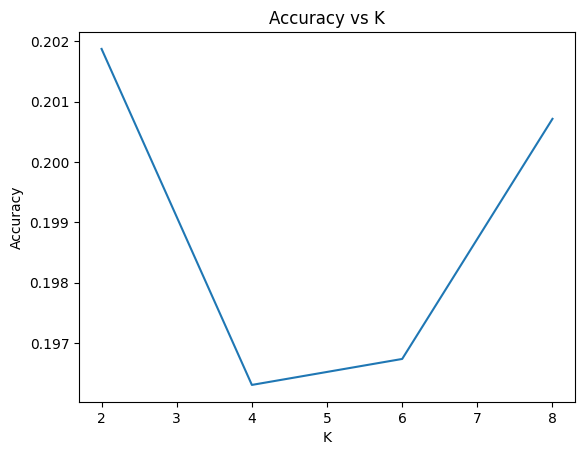

In [126]:
LinePlot("Accuracy",Accuracy,Nmin,Nmax,'N',0)
LinePlot("Accuracy",Accuracy,Dmin,Dmax,'D',1)
LinePlot("Accuracy",Accuracy,Lmin,Lmax,'L',2)
LinePlot("Accuracy",Accuracy,Kmin,Kmax,'K',3)

#### Test time

1.4539559682210287e-06
0.00011164387067159017


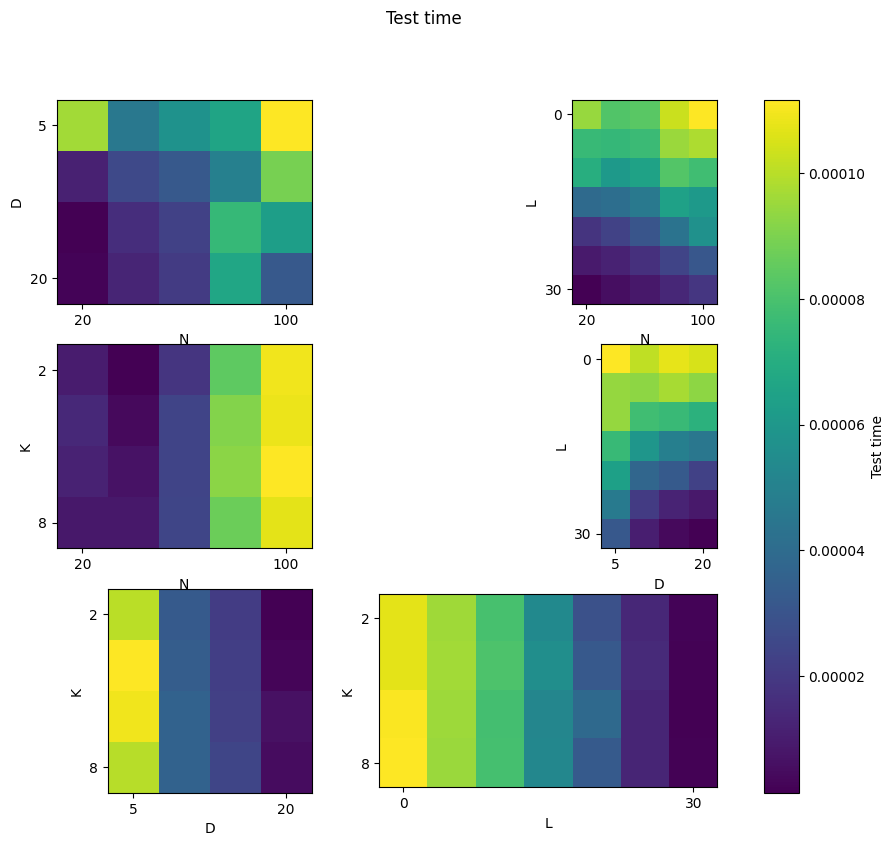

In [127]:
PixPlot("Test time",Test_time,
        [Nmin]*3+2*[Dmin]+[Lmin],
        [Nmax]*3+2*[Dmax]+[Lmax],
        [Dmin,Lmin,Kmin,Lmin,Kmin,Kmin],
        [Dmax,Lmax,Kmax,Lmax,Kmax,Kmax],
        ['N']*3+['D']*2+['L'],
        ['D','L','K','L','K','K'],
        [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        )

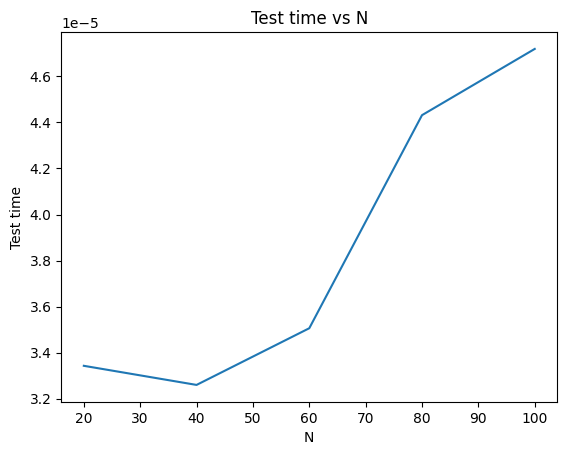

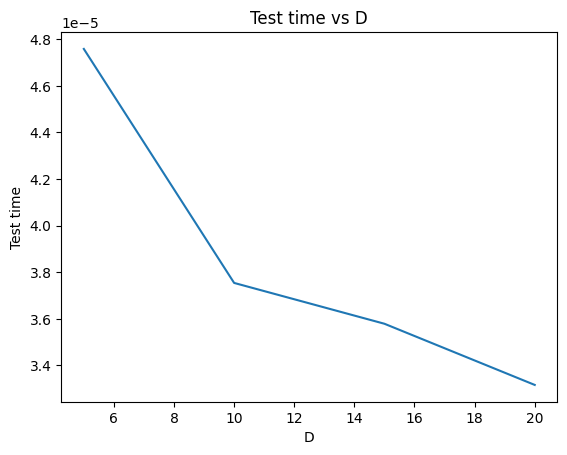

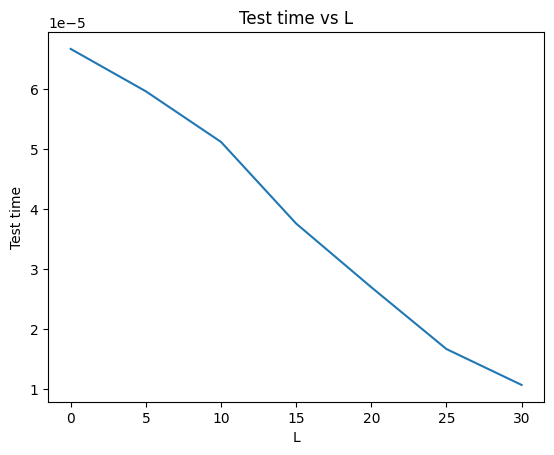

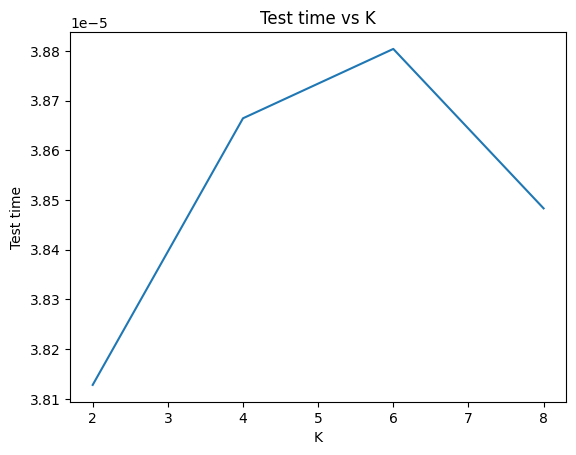

In [128]:
LinePlot("Test time",Test_time,Nmin,Nmax,'N',0)
LinePlot("Test time",Test_time,Dmin,Dmax,'D',1)
LinePlot("Test time",Test_time,Lmin,Lmax,'L',2)
LinePlot("Test time",Test_time,Kmin,Kmax,'K',3)

##### Conclusion :

Test time doesn't depend much on $ K $, and decreases with $ L $ and increases with $ N $, in agreement with our estimate of $ O(DL + \frac{DN}{2^L}) $. It decreases with $ D $ rather than increasing with it, not in agreement with the estimate.

### Naive KNN

This is essentially the LSH version with $L=1$ . 

In [129]:
Train_time_Naive = Train_time[:,:,0,:]
Test_time_Naive = Test_time[:,:,0,:]
Accuracy_Naive = Accuracy[:,:,0,:]

#### Train time

0.00013309319814046224
0.0003572543462117513


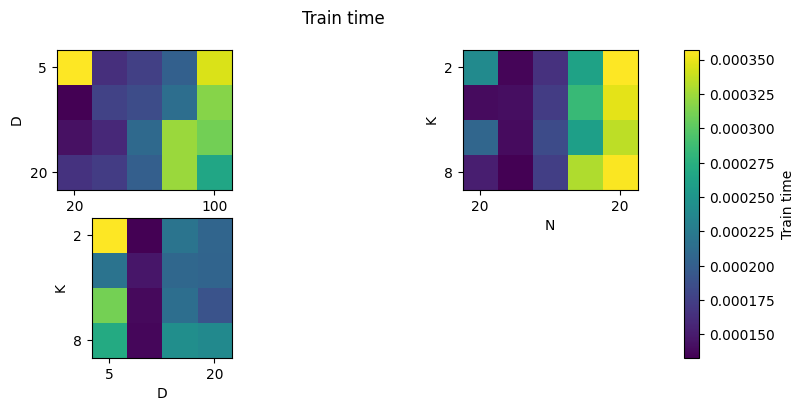

In [130]:
PixPlot("Train time",Train_time_Naive,
        [Nmin,Nmin,Dmin],
        [Nmax,Nmin,Dmax],
        [Dmin,Kmin,Kmin],
        [Dmax,Kmax,Kmax],
        ['N','N','D'],
        ['D','K','K'],
        [(0,1),(0,2),(1,2)]
        )

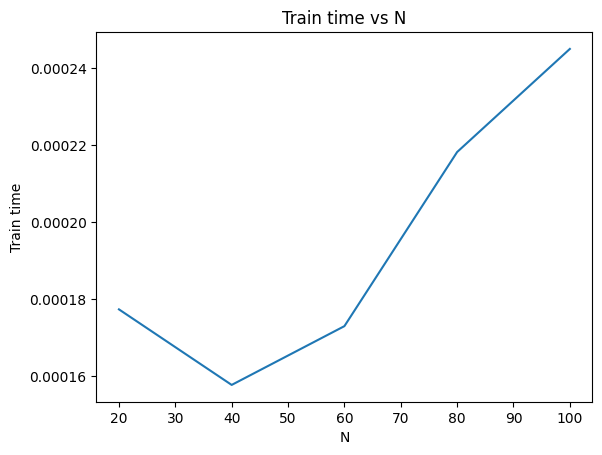

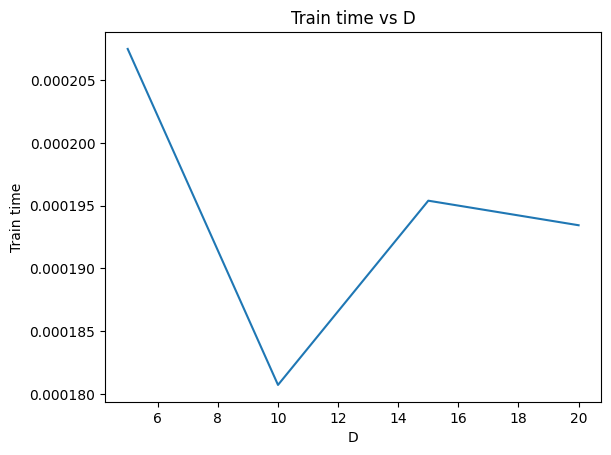

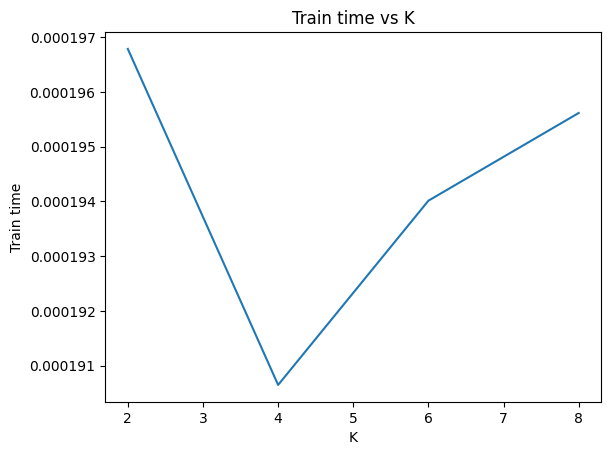

In [131]:
LinePlot("Train time",Train_time_Naive,Nmin,Nmax,'N',0)
LinePlot("Train time",Train_time_Naive,Dmin,Dmax,'D',1)
LinePlot("Train time",Train_time_Naive,Kmin,Kmax,'K',2)

#### Test time

5.559921264648437e-05
0.00010322968165079753


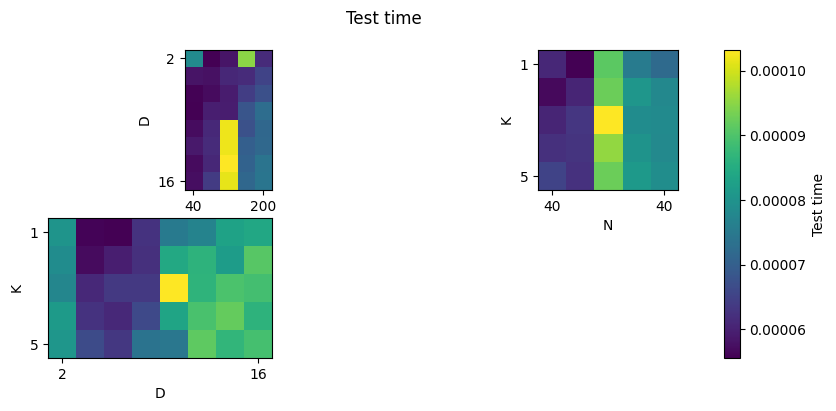

In [114]:
PixPlot("Test time",Test_time_Naive,
        [Nmin,Nmin,Dmin],
        [Nmax,Nmin,Dmax],
        [Dmin,Kmin,Kmin],
        [Dmax,Kmax,Kmax],
        ['N','N','D'],
        ['D','K','K'],
        [(0,1),(0,2),(1,2)]
        )

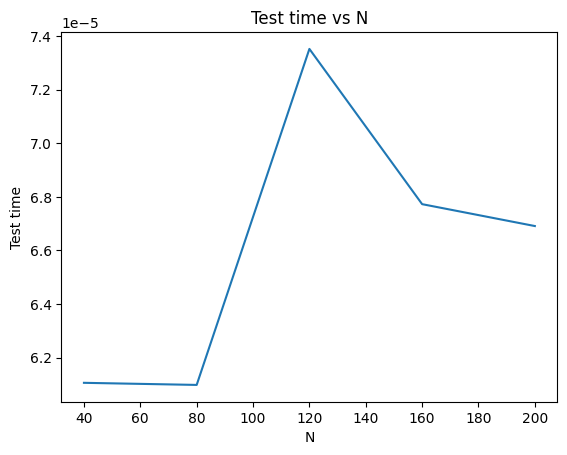

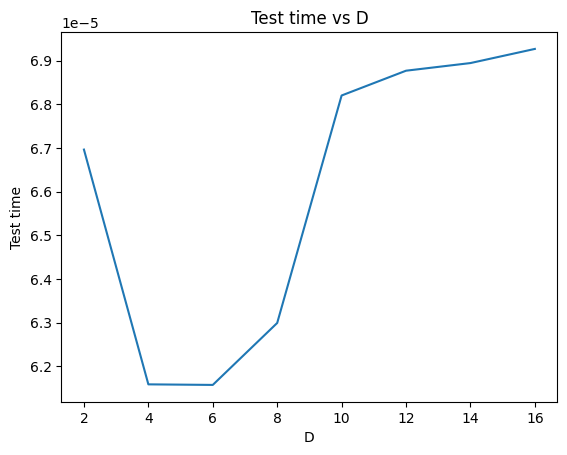

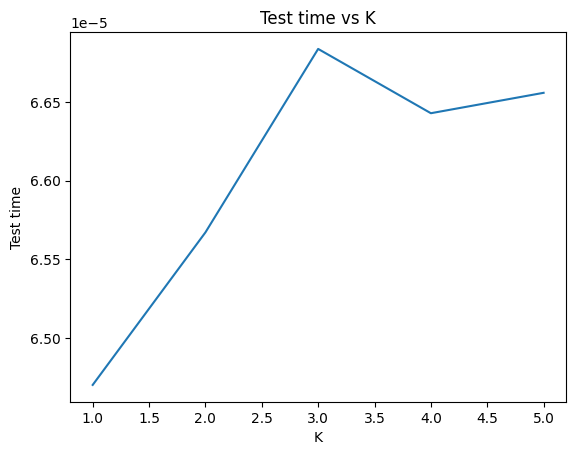

In [115]:
LinePlot("Test time",Test_time_Naive,Nmin,Nmax,'N',0)
LinePlot("Test time",Test_time_Naive,Dmin,Dmax,'D',1)
LinePlot("Test time",Test_time_Naive,Kmin,Kmax,'K',2)

#### Accuracy

5.559921264648437e-05
0.00010322968165079753


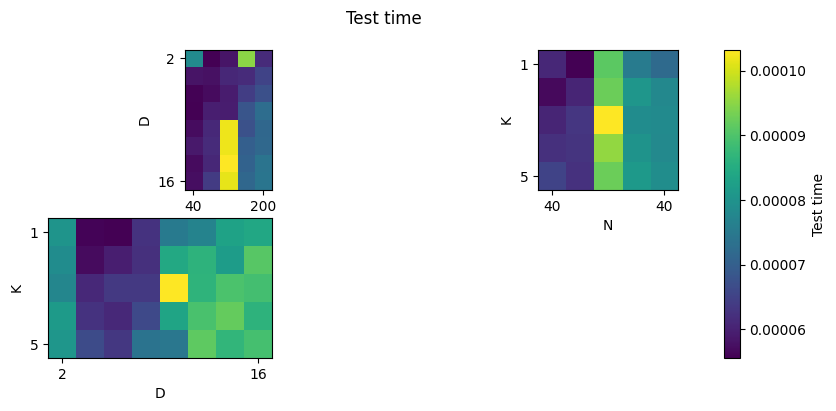

In [116]:
PixPlot("Test time",Test_time_Naive,
        [Nmin,Nmin,Dmin],
        [Nmax,Nmin,Dmax],
        [Dmin,Kmin,Kmin],
        [Dmax,Kmax,Kmax],
        ['N','N','D'],
        ['D','K','K'],
        [(0,1),(0,2),(1,2)]
        )

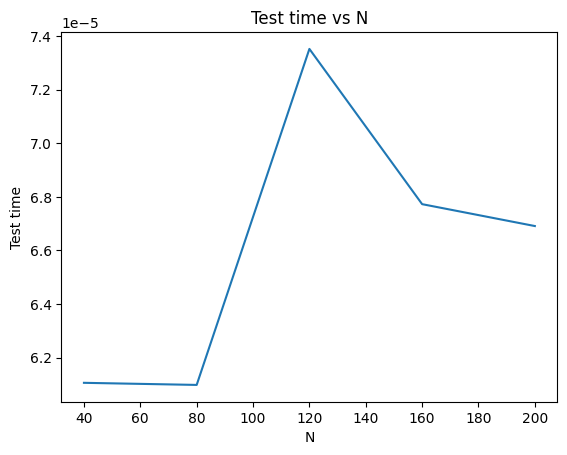

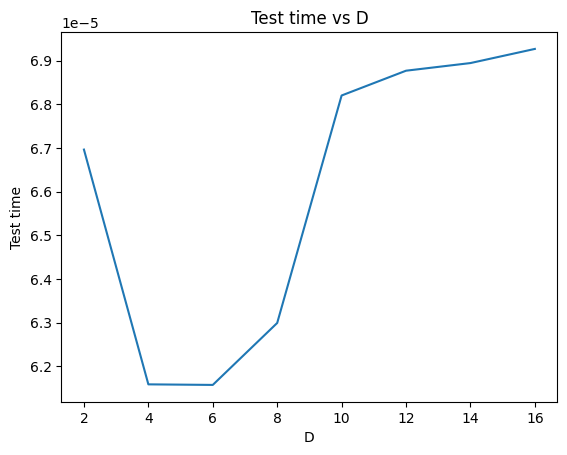

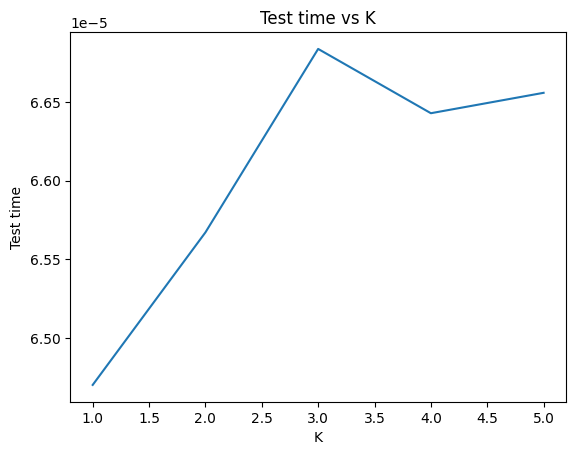

In [117]:
LinePlot("Test time",Test_time_Naive,Nmin,Nmax,'N',0)
LinePlot("Test time",Test_time_Naive,Dmin,Dmax,'D',1)
LinePlot("Test time",Test_time_Naive,Kmin,Kmax,'K',2)